<a href="https://colab.research.google.com/github/AntonDozhdikov/Demography_migration/blob/main/8_MADDPG_EVO_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# -*- coding: utf-8 -*-

"""
Multi-agent reinforcement learning system for modeling
demographic policy of Russian regions

Main goal: optimization of demographic policy in Russian regions
using a hybrid approach combining reinforcement learning methods
and evolutionary algorithms.

"""

# Import libraries for numerical computations and data processing
import numpy as np
import pandas as pd

# Import PyTorch libraries for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import data structures and random number generation module
from collections import defaultdict, deque
import random

# Import modules for JSON handling and plotting
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Import module for date and time handling
from datetime import datetime

# Import module for warning management
import warnings
warnings.filterwarnings('ignore')

# Setting random seeds for reproducibility of experimental results
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Setting up matplotlib for correct display of Russian text
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False


In [11]:
class DemographicDataProcessor:
    """Demographic data processor based on real regional data"""

    def __init__(self, real_data_path, crisis_scenarios_path):
        """Data processor initialization"""
        self.df = pd.read_csv(real_data_path)

        # Loading crisis scenarios from JSON file
        with open(crisis_scenarios_path, 'r') as f:
            self.crisis_scenarios = json.load(f)

        self.preprocess_data()

    def preprocess_data(self):
        """Preprocessing real data for modeling"""
        # Filling missing values
        self.df = self.df.fillna(method='ffill').fillna(method='bfill')

        # Calculating additional indicators where missing
        self.df.loc[self.df['natural_increase_rate'].isna(), 'natural_increase_rate'] = \
            self.df['birth_rate'] - self.df['death_rate']

        # Normalization of statistics by regions
        self.region_stats = {}

        for region in self.df['region_name'].unique():
            region_data = self.df[self.df['region_name'] == region]

            # Computing statistical indicators for the region
            self.region_stats[region] = {
                'birth_rate_mean': region_data['birth_rate'].mean(),
                'birth_rate_std': region_data['birth_rate'].std(),
                'death_rate_mean': region_data['death_rate'].mean(),
                'death_rate_std': region_data['death_rate'].std(),
                'migration_mean': region_data['migration_balance'].mean(),
                'migration_std': region_data['migration_balance'].std(),
                'gdp_mean': region_data['gdp_per_capita'].mean(),
                'gdp_std': region_data['gdp_per_capita'].std(),
                'unemployment_mean': region_data['unemployment_rate'].mean(),
                'unemployment_std': region_data['unemployment_rate'].std(),
                'population_trend': self._calculate_trend(region_data['population']),
                'region_id': region_data['region_id'].iloc[0]
            }

    def _calculate_trend(self, series):
        """Calculating time series trend"""
        series = series.dropna()
        if len(series) < 2:
            return 0
        x = np.arange(len(series))
        z = np.polyfit(x, series, 1)
        return z[0]

    def apply_crisis_impact(self, base_values, crisis_scenario, year, crisis_start_year):
        """Applying crisis impact on demographic indicators"""
        crisis_duration = year - crisis_start_year + 1
        max_duration = crisis_scenario['end_year'] - crisis_scenario['start_year'] + 1

        # Crisis intensity decreases over time
        intensity = max(0, 1 - (crisis_duration - 1) / max_duration)

        impacts = crisis_scenario['demographic_impacts']

        # Calculating impacts on each indicator
        birth_rate_impact = impacts['birth_rate_change'] * intensity
        death_rate_impact = impacts['death_rate_change'] * intensity
        migration_impact = impacts['migration_change'] * intensity
        economic_impact = impacts['economic_impact'] * intensity

        modified_values = base_values.copy()

        # Applying impacts to indicators
        modified_values['birth_rate'] *= (1 + birth_rate_impact)
        modified_values['death_rate'] *= (1 + death_rate_impact)
        modified_values['migration_balance'] *= (1 + migration_impact)
        modified_values['gdp_per_capita'] *= (1 + economic_impact)
        modified_values['unemployment_rate'] *= (1 - economic_impact * 0.5)

        return modified_values

    def generate_training_data(self, years, regions, apply_crisis=True):
        """Generating training data based on real data"""
        training_data = []

        for year in years:
            for region in regions:
                if region not in self.region_stats:
                    continue

                # Getting real data for region and year if available
                real_data = self.df[(self.df['region_name'] == region) & (self.df['year'] == year)]

                if len(real_data) > 0:
                    # Using real data
                    base_values = {
                        'region_id': real_data['region_id'].iloc[0],
                        'region_name': region,
                        'year': year,
                        'birth_rate': real_data['birth_rate'].iloc[0],
                        'death_rate': real_data['death_rate'].iloc[0],
                        'migration_balance': real_data['migration_balance'].iloc[0],
                        'gdp_per_capita': real_data['gdp_per_capita'].iloc[0],
                        'unemployment_rate': real_data['unemployment_rate'].iloc[0],
                        'population': real_data['population'].iloc[0],
                        'average_wage': real_data['average_wage'].iloc[0]
                    }
                else:
                    # Generating synthetic data based on statistics
                    stats = self.region_stats[region]
                    base_values = {
                        'region_id': stats['region_id'],
                        'region_name': region,
                        'year': year,
                        'birth_rate': max(0, np.random.normal(stats['birth_rate_mean'], stats['birth_rate_std'])),
                        'death_rate': max(0, np.random.normal(stats['death_rate_mean'], stats['death_rate_std'])),
                        'migration_balance': np.random.normal(stats['migration_mean'], stats['migration_std']),
                        'gdp_per_capita': max(0, np.random.normal(stats['gdp_mean'], stats['gdp_std'])),
                        'unemployment_rate': max(0, min(100, np.random.normal(stats['unemployment_mean'], stats['unemployment_std'])))
                    }

                # Applying crisis scenarios if necessary
                if apply_crisis:
                    for scenario in self.crisis_scenarios:
                        if scenario['start_year'] <= year <= scenario['end_year']:
                            base_values = self.apply_crisis_impact(
                                base_values, scenario, year, scenario['start_year']
                            )

                # Calculating derived indicators
                base_values['natural_increase_rate'] = base_values['birth_rate'] - base_values['death_rate']

                # Calculating population considering trend
                if 'population' not in base_values:
                    base_population = 1000000 + stats['population_trend'] * (year - 2010)
                    base_values['population'] = max(0, int(base_population +
                        (base_values['natural_increase_rate'] + base_values['migration_balance']/1000) * 1000))

                # Calculating average wage
                if 'average_wage' not in base_values or pd.isna(base_values['average_wage']):
                    base_values['average_wage'] = max(0, base_values['gdp_per_capita'] * 0.03 *
                        (1 - base_values['unemployment_rate']/100))

                training_data.append(base_values)

        return pd.DataFrame(training_data)

In [12]:
class DemographicEnvironment:
    """Multi-agent environment for demographic modeling"""

    def __init__(self, data, n_regions=8, max_steps=50):
        self.data = data
        # Getting first n_regions unique region names
        self.regions = data['region_name'].unique()[:n_regions]
        self.n_regions = len(self.regions)
        self.max_steps = max_steps
        self.current_step = 0

        # Dimensions of state and action spaces
        self.state_dim = 8  # main demographic indicators
        self.action_dim = 4  # policy actions

        self.reset()

    def reset(self):
        """Resetting environment to initial state"""
        self.current_step = 0
        self.states = {}
        self.histories = {region: [] for region in self.regions}

        # Initializing states of all regions
        for i, region in enumerate(self.regions):
            region_data = self.data[self.data['region_name'] == region].iloc[0]
            self.states[region] = self._normalize_state(region_data)

        return self.get_observations()

    def _normalize_state(self, region_data):
        """Regional state normalization"""
        return np.array([
            region_data['birth_rate'] / 20.0,  # Birth rate normalization
            region_data['death_rate'] / 30.0,  # Death rate normalization
            region_data['natural_increase_rate'] / 10.0,  # Natural increase normalization
            min(region_data['migration_balance'] / 100000.0, 1.0),  # Migration normalization
            region_data['gdp_per_capita'] / 2000000.0,  # GDP per capita normalization
            region_data['unemployment_rate'] / 100.0,  # Unemployment normalization
            region_data['population'] / 10000000.0,  # Population normalization
            region_data['average_wage'] / 200000.0  # Average wage normalization
        ])

    def get_observations(self):
        """Getting observations for all agents"""
        observations = {}

        for region in self.regions:
            # Local observation (current region state)
            obs = self.states[region].copy()

            # Collecting states of other regions
            other_states = [self.states[r] for r in self.regions if r != region]

            # Adding averaged information from other regions
            if other_states:
                avg_other = np.mean(other_states, axis=0)
                obs = np.concatenate([obs, avg_other])
            else:
                obs = np.concatenate([obs, np.zeros(self.state_dim)])

            observations[region] = obs

        return observations

    def step(self, actions):
        """Performing step in environment"""
        rewards = {}

        for region in self.regions:
            if region in actions:
                action = actions[region]
                old_state = self.states[region].copy()

                # Updating region state based on action
                self.states[region] = self._apply_policy_action(self.states[region], action)

                # Calculating reward for transition from old to new state
                rewards[region] = self._calculate_reward(old_state, self.states[region])

                # Saving step history
                self.histories[region].append({
                    'step': self.current_step,
                    'state': old_state.copy(),
                    'action': action.copy(),
                    'reward': rewards[region]
                })

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return self.get_observations(), rewards, done, {}

    def _apply_policy_action(self, state, action):
        """Applying policy actions to region state"""
        new_state = state.copy()

        # action[0] - maternity capital (affects birth rate)
        # action[1] - healthcare (affects mortality)
        # action[2] - migration policy (affects migration)
        # action[3] - economic incentives (affects GDP and unemployment)

        birth_rate_change = action[0] * 0.1
        death_rate_change = -action[1] * 0.05
        migration_change = action[2] * 0.05
        economic_change = action[3] * 0.02

        # Updating indicators considering actions and constraints
        new_state[0] = max(0, new_state[0] + birth_rate_change)  # birth rate
        new_state[1] = max(0, new_state[1] + death_rate_change)  # mortality
        new_state[2] = new_state[0] - new_state[1]  # natural increase
        new_state[3] = new_state[3] + migration_change  # migration balance
        new_state[4] = max(0, new_state[4] + economic_change)  # GDP per capita
        new_state[5] = max(0, min(1, new_state[5] - economic_change * 0.5))  # unemployment

        # Updating population size
        population_change = (new_state[2] + new_state[3]) * 0.01
        new_state[6] = max(0, new_state[6] + population_change)  # population

        # Updating average wage
        new_state[7] = new_state[4] * 0.1 * (1 - new_state[5])  # average wage

        return new_state

    def _calculate_reward(self, old_state, new_state):
        """Calculating reward based on demographic indicator improvement"""
        # Positive indicator changes (with weights)
        birth_rate_improvement = (new_state[0] - old_state[0]) * 10
        death_rate_improvement = (old_state[1] - new_state[1]) * 10
        natural_increase_improvement = (new_state[2] - old_state[2]) * 15
        migration_improvement = (new_state[3] - old_state[3]) * 5
        gdp_improvement = (new_state[4] - old_state[4]) * 5
        unemployment_improvement = (old_state[5] - new_state[5]) * 5

        # Penalty for population instability
        population_stability = -abs(new_state[6] - old_state[6]) * 2

        # Summing all reward components
        total_reward = (birth_rate_improvement + death_rate_improvement +
                       natural_increase_improvement + migration_improvement +
                       gdp_improvement + unemployment_improvement + population_stability)

        return total_reward

In [13]:
class ActorNetwork(nn.Module):
    """Actor network for MADDPG"""

    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(ActorNetwork, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # actions from -1 to 1
        return x

class CriticNetwork(nn.Module):
    """Critic network for MADDPG"""

    def __init__(self, state_dim, action_dim, n_agents, hidden_dim=256):
        super(CriticNetwork, self).__init__()

        # Calculating input size (states and actions of all agents)
        total_input_dim = state_dim * n_agents + action_dim * n_agents

        self.fc1 = nn.Linear(total_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [14]:
class MADDPGAgent:
    """MADDPG Agent"""

    def __init__(self, agent_id, state_dim, action_dim, n_agents, lr_actor=1e-4, lr_critic=1e-3):
        self.agent_id = agent_id
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_agents = n_agents

        # Actor networks (main and target)
        self.actor = ActorNetwork(state_dim, action_dim)
        self.actor_target = ActorNetwork(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        # Critic networks (main and target)
        self.critic = CriticNetwork(state_dim, action_dim, n_agents)
        self.critic_target = CriticNetwork(state_dim, action_dim, n_agents)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Initializing target networks by copying weights from main ones
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)

        # Training parameters
        self.gamma = 0.95  # discount factor
        self.tau = 0.02    # soft update parameter

    def act(self, state, noise_scale=0.1):
        """Action selection with noise for exploration"""
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).squeeze(0).detach().numpy()

        # Adding noise for exploration
        noise = np.random.normal(0, noise_scale, size=action.shape)
        action = np.clip(action + noise, -1, 1)

        return action

    def hard_update(self, target, source):
        """Hard update of target network parameters"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, target, source):
        """Soft update of target network parameters"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)


In [15]:
class EvolutionaryBooster:
    """Evolutionary booster for MARL agent optimization"""

    def __init__(self, population_size=20, mutation_rate=0.1, crossover_rate=0.7):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = []
        self.fitness_history = []

    def initialize_population(self, agent_template):
        """Agent population initialization"""
        self.population = []

        for _ in range(self.population_size):
            agent_copy = self._copy_agent(agent_template)
            self._mutate_agent(agent_copy, mutation_strength=0.3)
            self.population.append(agent_copy)

    def _copy_agent(self, agent):
        """Creating agent copy"""
        new_agent = MADDPGAgent(agent.agent_id, agent.state_dim, agent.action_dim, agent.n_agents)
        new_agent.actor.load_state_dict(agent.actor.state_dict())
        new_agent.critic.load_state_dict(agent.critic.state_dict())
        return new_agent

    def _mutate_agent(self, agent, mutation_strength=0.1):
        """Agent parameter mutation"""
        # Actor network parameter mutation
        for param in agent.actor.parameters():
            if np.random.random() < self.mutation_rate:
                noise = torch.randn_like(param) * mutation_strength
                param.data += noise

        # Critic network parameter mutation
        for param in agent.critic.parameters():
            if np.random.random() < self.mutation_rate:
                noise = torch.randn_like(param) * mutation_strength
                param.data += noise

    def _crossover_agents(self, parent1, parent2):
        """Crossover of two agents"""
        child1 = self._copy_agent(parent1)
        child2 = self._copy_agent(parent2)

        # Actor parameter crossover
        for p1, p2, c1, c2 in zip(parent1.actor.parameters(), parent2.actor.parameters(),
                                 child1.actor.parameters(), child2.actor.parameters()):
            if np.random.random() < self.crossover_rate:
                mask = torch.rand_like(p1) > 0.5
                c1.data = torch.where(mask, p1.data, p2.data)
                c2.data = torch.where(mask, p2.data, p1.data)

        return child1, child2

    def evolve_population(self, fitness_scores):
        """Population evolution based on fitness function"""
        # Combining agents and their fitness, sorting by fitness
        population_fitness = list(zip(self.population, fitness_scores))
        population_fitness.sort(key=lambda x: x[1], reverse=True)

        # Selection of best individuals (elite)
        elite_size = self.population_size // 4
        elite = [agent for agent, _ in population_fitness[:elite_size]]

        # Creating new generation
        new_population = elite.copy()

        # Filling population to required size
        while len(new_population) < self.population_size:
            parent1 = self._tournament_selection(population_fitness)
            parent2 = self._tournament_selection(population_fitness)

            if np.random.random() < self.crossover_rate:
                child1, child2 = self._crossover_agents(parent1, parent2)
                self._mutate_agent(child1)
                self._mutate_agent(child2)
                new_population.extend([child1, child2])
            else:
                child = self._copy_agent(parent1)
                self._mutate_agent(child)
                new_population.append(child)

        # Trimming population to required size and updating
        self.population = new_population[:self.population_size]

        # Saving fitness history
        self.fitness_history.append(max(fitness_scores))

        return self.population[0]  # returning best agent

    def _tournament_selection(self, population_fitness, tournament_size=3):
        """Tournament parent selection"""
        tournament = random.sample(population_fitness, min(tournament_size, len(population_fitness)))
        return max(tournament, key=lambda x: x[1])[0]

In [16]:
class ExperimentLogger:
    """Logger for experiment result recording and visualization"""

    def __init__(self):
        self.metrics = defaultdict(list)
        self.episode_rewards = defaultdict(list)
        self.evolution_history = []

    def log_episode(self, episode, agent_rewards, avg_reward, stability_metric):
        """Episode result logging"""
        self.metrics['episode'].append(episode)
        self.metrics['avg_reward'].append(avg_reward)
        self.metrics['stability'].append(stability_metric)

        # Saving rewards for each agent
        for agent_id, reward in agent_rewards.items():
            self.episode_rewards[agent_id].append(reward)

    def log_evolution(self, generation, best_fitness, avg_fitness):
        """Logging evolution results"""
        self.evolution_history.append({
            'generation': generation,
            'best_fitness': best_fitness,
            'avg_fitness': avg_fitness
        })

    def plot_results(self):
        """Result visualization"""
        plt.figure(figsize=(15, 10))

        # Chart 1: Average Reward per Episode
        plt.subplot(2, 3, 1)
        plt.plot(self.metrics['episode'], self.metrics['avg_reward'])
        plt.title('Average Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)

        # Chart 2: Stability Metric
        plt.subplot(2, 3, 2)
        plt.plot(self.metrics['episode'], self.metrics['stability'])
        plt.title('System Stability Metric')
        plt.xlabel('Episode')
        plt.ylabel('Stability')
        plt.grid(True)

        # Chart 3: Agent rewards (first 50 episodes)
        plt.subplot(2, 3, 3)
        for agent_id, rewards in self.episode_rewards.items():
            plt.plot(rewards[:50], label=f'Agent {agent_id}', alpha=0.7)
        plt.title('Agent Rewards (First 50 Episodes)')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True)

        # Chart 4: Population Evolution (if data available)
        if self.evolution_history:
            plt.subplot(2, 3, 4)
            generations = [x['generation'] for x in self.evolution_history]
            best_fitness = [x['best_fitness'] for x in self.evolution_history]
            avg_fitness = [x['avg_fitness'] for x in self.evolution_history]

            plt.plot(generations, best_fitness, label='Best Fitness', linewidth=2)
            plt.plot(generations, avg_fitness, label='Average Fitness', alpha=0.7)
            plt.title('Population Evolution')
            plt.xlabel('Generation')
            plt.ylabel('Fitness')
            plt.legend()
            plt.grid(True)

        # Chart 5: Reward Distribution
        plt.subplot(2, 3, 5)
        all_rewards = []
        for rewards in self.episode_rewards.values():
            all_rewards.extend(rewards)

        plt.hist(all_rewards, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Reward Distribution')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')
        plt.grid(True)

        # Chart 6: Moving Average of Rewards
        plt.subplot(2, 3, 6)
        window_size = 10
        if len(self.metrics['avg_reward']) >= window_size:
            moving_avg = pd.Series(self.metrics['avg_reward']).rolling(window=window_size).mean()
            plt.plot(self.metrics['episode'], moving_avg)
            plt.title(f'Moving Average of Rewards (window {window_size})')
            plt.xlabel('Episode')
            plt.ylabel('Moving Average')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    def save_results(self, filename):
        """Saving results to CSV"""
        results_df = pd.DataFrame(self.metrics)
        results_df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")

In [17]:
# Main MADDPG training function with evolutionary boosters
def train_maddpg_with_evolution(env, n_episodes=200, evolution_frequency=50,
                               population_size=10, save_results=True):
    """Main MADDPG training function with evolutionary boosters"""
    print("Initializing training system...")

    # Initializing agents for each region
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MADDPGAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,  # local + global state
            action_dim=env.action_dim,
            n_agents=env.n_regions
        )

    # Initializing evolutionary boosters for each region
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBooster(population_size=population_size)
        booster.initialize_population(agents[region])
        evolution_boosters[region] = booster

    # Creating replay buffers for each agent
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}

    # Creating result logger
    logger = ExperimentLogger()

    print(f"Starting training on {n_episodes} episodes...")

    # Main training loop over episodes
    for episode in range(n_episodes):
        states = env.reset()
        episode_rewards = {region: 0 for region in env.regions}

        # Step loop within episode
        for step in range(env.max_steps):
            # Selecting actions for all agents
            actions = {}
            for region in env.regions:
                action = agents[region].act(states[region], noise_scale=0.1)
                actions[region] = action

            # Performing step in environment
            next_states, rewards, done, _ = env.step(actions)

            # Saving experience to replay buffers
            for region in env.regions:
                replay_buffers[region].append((
                    states[region], actions[region], rewards[region],
                    next_states[region], done
                ))
                episode_rewards[region] += rewards[region]

            states = next_states

            if done:
                break

        # Agent training (every 10 episodes, starting from 10th)
        if episode % 10 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 100:
                    _train_agent(agents[region], replay_buffers[region], batch_size=32)

        # Evolutionary optimization (at specified frequency, starting from first optimization)
        if episode % evolution_frequency == 0 and episode > 0:
            print(f"Evolutionary optimization at episode {episode}...")
            for region in env.regions:
                # Evaluating fitness of entire population
                fitness_scores = []
                for agent in evolution_boosters[region].population:
                    fitness = _evaluate_agent_fitness(agent, env, region)
                    fitness_scores.append(fitness)

                # Population evolution and obtaining best agent
                best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                agents[region] = best_agent

                # Logging evolution results
                logger.log_evolution(
                    episode // evolution_frequency,
                    max(fitness_scores),
                    np.mean(fitness_scores)
                )

        # Episode result logging
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)

        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)

        # Progress output (every 20 episodes)
        if episode % 20 == 0:
            print(f"Episode {episode}, average reward: {avg_reward:.3f}, "
                  f"stability: {stability_metric:.3f}")

    print("Training completed!")

    # Visualization and saving results
    logger.plot_results()

    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"maddpg_evolution_results_{timestamp}.csv")

    return agents, logger

def _train_agent(agent, replay_buffer, batch_size=32):
    """Training single MADDPG agent"""
    if len(replay_buffer) < batch_size:
        return

    # Random batch extraction from buffer
    batch = random.sample(replay_buffer, batch_size)

    # Splitting batch into components
    states = torch.FloatTensor([x[0] for x in batch])
    actions = torch.FloatTensor([x[1] for x in batch])
    rewards = torch.FloatTensor([x[2] for x in batch]).unsqueeze(1)
    next_states = torch.FloatTensor([x[3] for x in batch])
    dones = torch.BoolTensor([x[4] for x in batch]).unsqueeze(1)

    # Critic update
    with torch.no_grad():
        next_actions = agent.actor_target(next_states)
        global_next_states = next_states.repeat(1, agent.n_agents).view(batch_size, -1)
        global_next_actions = next_actions.repeat(1, agent.n_agents).view(batch_size, -1)
        target_q = agent.critic_target(global_next_states, global_next_actions)
        target_q = rewards + agent.gamma * target_q * (~dones)

    global_states = states.repeat(1, agent.n_agents).view(batch_size, -1)
    global_actions = actions.repeat(1, agent.n_agents).view(batch_size, -1)
    current_q = agent.critic(global_states, global_actions)

    critic_loss = F.mse_loss(current_q, target_q)

    agent.critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
    agent.critic_optimizer.step()

    # Actor update
    predicted_actions = agent.actor(states)
    global_predicted_actions = predicted_actions.repeat(1, agent.n_agents).view(batch_size, -1)
    actor_loss = -agent.critic(global_states, global_predicted_actions).mean()

    agent.actor_optimizer.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 0.5)
    agent.actor_optimizer.step()

    # Soft update of target networks
    agent.soft_update(agent.actor_target, agent.actor)
    agent.soft_update(agent.critic_target, agent.critic)

def _evaluate_agent_fitness(agent, env, region, n_eval_episodes=3):
    """Agent fitness evaluation"""
    total_reward = 0

    for _ in range(n_eval_episodes):
        states = env.reset()
        episode_reward = 0

        for _ in range(env.max_steps):
            action = agent.act(states[region], noise_scale=0.0)
            actions = {region: action}

            # Adding random actions for other agents
            for other_region in env.regions:
                if other_region != region:
                    actions[other_region] = np.random.uniform(-1, 1, env.action_dim)

            next_states, rewards, done, _ = env.step(actions)
            episode_reward += rewards.get(region, 0)
            states = next_states

            if done:
                break

        total_reward += episode_reward

    return total_reward / n_eval_episodes

def _calculate_stability_metric(env):
    """Calculating demographic system stability metric"""
    stability_scores = []

    for region in env.regions:
        state = env.states[region]

        # Calculating stability as average of three components:
        # 1. Birth-death balance
        natural_balance = abs(state[2])
        # 2. Economic stability
        economic_stability = 1 - state[5]
        # 3. Migration stability
        migration_stability = 1 / (1 + abs(state[3]) * 10)

        region_stability = (natural_balance + economic_stability + migration_stability) / 3
        stability_scores.append(region_stability)

    return np.mean(stability_scores)

=== MULTI-AGENT REINFORCEMENT LEARNING SYSTEM ===
=== FOR DEMOGRAPHIC MODELING OF RUSSIAN REGIONS ===

Loading and processing real data...
Processed 40 records for 8 regions
Creating multi-agent environment...
Environment created for 8 regions: ['Moscow', 'St. Petersburg', 'Tatarstan', 'Krasnodar Krai', 'Sverdlovsk Oblast', 'Novosibirsk Oblast', 'Samara Oblast', 'Rostov Oblast']
Launching MADDPG experiment with evolutionary boosters...
Initializing training system...
Starting training on 100 episodes...
Episode 0, average reward: 106.463, stability: 1.527
Episode 20, average reward: 106.258, stability: 1.515
Evolutionary optimization at episode 25...
Episode 40, average reward: 144.940, stability: 0.932
Evolutionary optimization at episode 50...
Episode 60, average reward: 151.753, stability: 0.929
Evolutionary optimization at episode 75...
Episode 80, average reward: 162.542, stability: 0.874
Training completed!


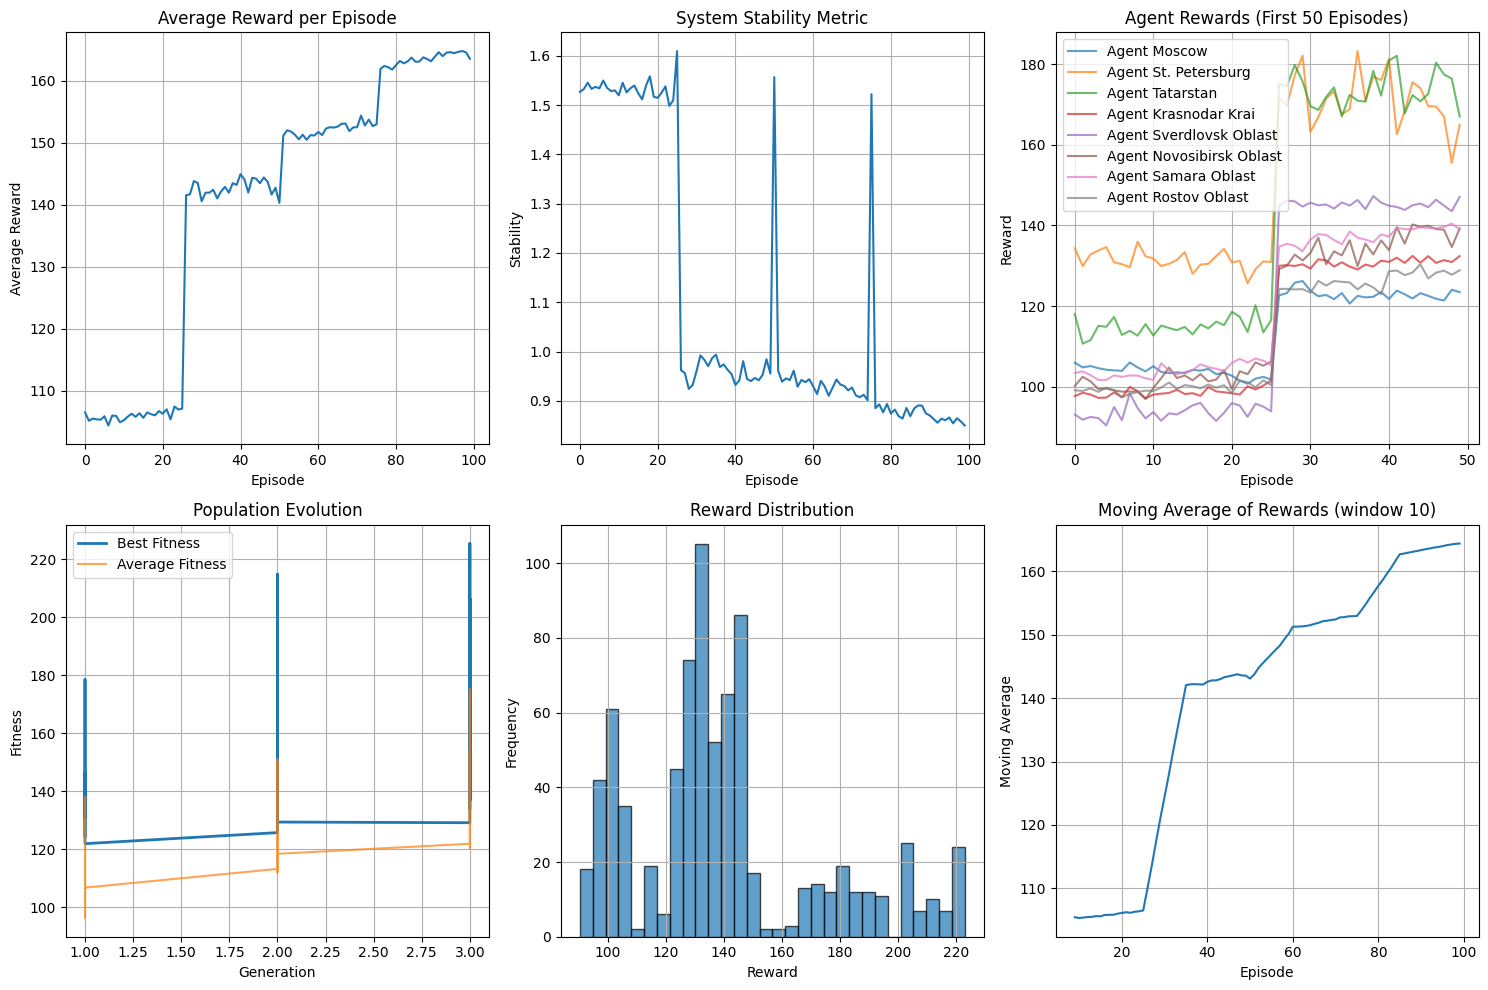

Results saved to maddpg_evolution_results_20250909_100548.csv

=== EXPERIMENT COMPLETED ===
Trained 8 agents
Results visualized and saved

=== FINAL ASSESSMENT ===
Region Moscow: final fitness = 127.716
Region St. Petersburg: final fitness = 226.730
Region Tatarstan: final fitness = 195.046
Region Krasnodar Krai: final fitness = 138.894
Region Sverdlovsk Oblast: final fitness = 146.854
Region Novosibirsk Oblast: final fitness = 159.886
Region Samara Oblast: final fitness = 207.441
Region Rostov Oblast: final fitness = 138.286
Average final fitness: 167.607
Standard deviation: 34.643


In [18]:
# System usage demonstration
if __name__ == "__main__":
    print("=== MULTI-AGENT REINFORCEMENT LEARNING SYSTEM ===")
    print("=== FOR DEMOGRAPHIC MODELING OF RUSSIAN REGIONS ===")
    print()

    # Processing real data
    print("Loading and processing real data...")
    data_processor = DemographicDataProcessor(
        'regions_data_selective.csv',  # path to real data
        'crisis.txt'  # path to crisis scenarios
    )

    # Generating data for experiments
    years = list(range(2020, 2025))
    target_regions = ['Moscow', 'St. Petersburg', 'Tatarstan', 'Krasnodar Krai',
                     'Sverdlovsk Oblast', 'Novosibirsk Oblast', 'Samara Oblast', 'Rostov Oblast']

    training_data = data_processor.generate_training_data(years, target_regions, apply_crisis=True)
    print(f"Processed {len(training_data)} records for {len(target_regions)} regions")

    # Creating environment
    print("Creating multi-agent environment...")
    env = DemographicEnvironment(training_data, n_regions=8, max_steps=30)
    print(f"Environment created for {env.n_regions} regions: {list(env.regions)}")

    # Starting training
    print("Launching MADDPG experiment with evolutionary boosters...")
    trained_agents, experiment_logger = train_maddpg_with_evolution(
        env,
        n_episodes=100,       # reduced number of episodes
        evolution_frequency=25, # evolutionary optimization frequency
        population_size=8,    # reduced population size
        save_results=True     # saving results
    )

    print("\n=== EXPERIMENT COMPLETED ===")
    print(f"Trained {len(trained_agents)} agents")
    print("Results visualized and saved")

    # Final performance evaluation
    print("\n=== FINAL ASSESSMENT ===")
    final_rewards = []
    for region, agent in trained_agents.items():
        fitness = _evaluate_agent_fitness(agent, env, region, n_eval_episodes=5)
        final_rewards.append(fitness)
        print(f"Region {region}: final fitness = {fitness:.3f}")

    print(f"Average final fitness: {np.mean(final_rewards):.3f}")
    print(f"Standard deviation: {np.std(final_rewards):.3f}")